#Aviation Price Prediction - By Prateek Dutta

The objective of the study is to analyse the flight booking dataset obtained from “Ease My Trip” website and to conduct various statistical hypothesis tests in order to get meaningful information from it. The 'Linear Regression' statistical algorithm would be used to train the dataset and predict a continuous target variable. 'Easemytrip' is an internet platform for booking flight tickets, and hence a platform that potential passengers use to buy tickets. A thorough study of the data will aid in the discovery of valuable insights that will be of enormous value to passengers.

**DATA COLLECTION AND METHODOLOGY**

Octoparse scraping tool was used to extract data from the website. Data was collected in two parts: one for economy class tickets and another for business class tickets. A total of 300261 distinct flight booking options was extracted from the site. Data was collected for 50 days, from February 11th to March 31st, 2022.
Data source was secondary data and was collected from Ease my trip website.

**DATASET**

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset.

**FEATURES**

The various features of the cleaned dataset are explained below:
1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.

2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.

3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.

4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.

5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.

6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.

7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.

8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.

9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.

10)Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.

11) Price: Target variable stores information of the ticket price.

**Tools & Techniques:-**

Python[Language]

Numpy, Pandas, Matplotlib, Seaborn, sklearn, lightgbm, tensorflow [Libraries]

Data Cleaning

In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Flight Price Predict/

/gdrive/MyDrive/Flight Price Predict


In [9]:
ls

X_test.csv  X_train.csv  y_test.csv  y_train.csv


# Flight Price Predict and Visualize Importance

In [6]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.4 MB/s 


In [8]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [10]:
X_train=pd.read_csv('X_train.csv')
Y_train=pd.read_csv('y_train.csv')
X_test=pd.read_csv('X_test.csv')
Y_test=pd.read_csv('y_test.csv')

In [11]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [12]:
X_train2=labelencoder(X_train)
X_test2=labelencoder(X_test)

In [13]:
n=len(X_train2)
print(n)
N=list(range(n))
random.seed(2021)
random.shuffle(N)

5698


In [14]:
target=['price']
trainY = Y_train[target]
trainX = X_train.drop('filghtId',axis=1)
testY = Y_test[target]
testX = X_test.drop('filghtId',axis=1)

In [15]:
df_columns = list(trainX.columns)
print(df_columns)

['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'duration', 'days_left']


In [16]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [17]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [18]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [19]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|██████████| 1/1 [00:00<00:00, 125.92it/s]

createcreate_numeric_feature  0.004[s]



100%|██████████| 1/1 [00:00<00:00, 261.43it/s]

createcreate_numeric_feature  0.002[s]


# Model

In [20]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [21]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [22]:
y = trainY
ydf=pd.DataFrame(y)
display(ydf)

,price
0,69244
1,52392
2,61933
3,53164
4,42521
...,...
5693,61032
5694,60260
5695,51697
5696,51707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6161.68
Early stopping, best iteration is:
[632]	valid_0's rmse: 6138.04
fit fold=0  4.464[s]
Fold 0 RMSLE: 6138.0363

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6672.52
[1000]	valid_0's rmse: 6496.63
Early stopping, best iteration is:
[1330]	valid_0's rmse: 6447.91
fit fold=1  4.169[s]
Fold 1 RMSLE: 6447.9093

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6515.56
Early stopping, best iteration is:
[653]	valid_0's rmse: 6498.71
fit fold=2  0.819[s]
Fold 2 RMSLE: 6498.7119

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 5886.5
Early stopping, best iteration is:
[668]	valid_0's rmse: 5802.23
fit fold=3  0.837[s]
Fold 3 RMSLE: 5802.2344

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6376.49
Early stopping, best iteration is:
[751]	valid_0's rmse: 628

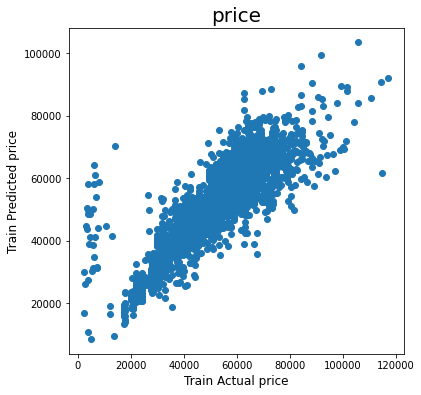

In [23]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_ylabel('Train Predicted '+target[i],fontsize=12)
    ax.set_xlabel('Train Actual '+target[i],fontsize=12)
    ax.scatter(y,oof)

# Visualize Importance

In [24]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6161.68
Early stopping, best iteration is:
[632]	valid_0's rmse: 6138.04
fit fold=0  0.813[s]
Fold 0 RMSLE: 6138.0363

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6672.52
[1000]	valid_0's rmse: 6496.63
Early stopping, best iteration is:
[1330]	valid_0's rmse: 6447.91
fit fold=1  1.577[s]
Fold 1 RMSLE: 6447.9093

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6515.56
Early stopping, best iteration is:
[653]	valid_0's rmse: 6498.71
fit fold=2  0.840[s]
Fold 2 RMSLE: 6498.7119

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 5886.5
Early stopping, best iteration is:
[668]	valid_0's rmse: 5802.23
fit fold=3  0.833[s]
Fold 3 RMSLE: 5802.2344

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 6376.49
Early stopping, best iteration is:
[751]	valid_0's rmse: 628

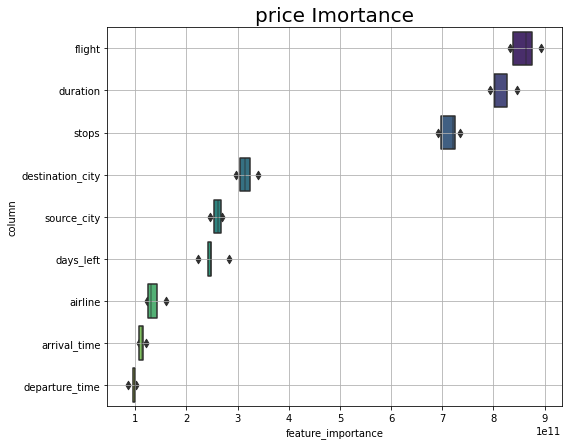

In [25]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [26]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
print(predsT.shape)
preds2=[]
for item in predsT:
    preds2+=[sum(item)]
print(np.array(preds2).shape)

(3347, 5)
(3347,)


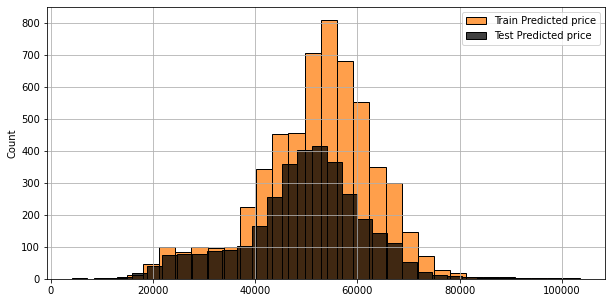

In [27]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

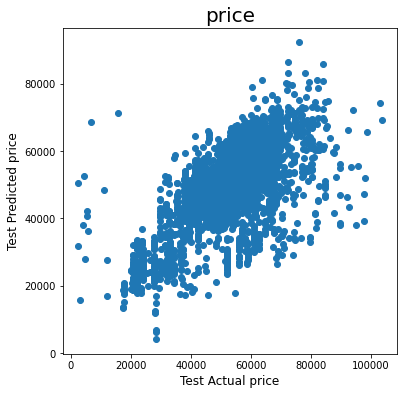

In [28]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(target[i],fontsize=20)
ax.set_ylabel('Test Predicted '+target[i],fontsize=12)
ax.set_xlabel('Test Actual '+target[i],fontsize=12)
ax.scatter(testY,preds2)